<a href="https://colab.research.google.com/github/Kishou-Arima/NCA_MNIST/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Could not load all digit models. Proceeding with default initialization.
[Unified NCA] Epoch 1: Train Loss = 30.4585, Val Loss = 1.8184
[Unified NCA] Epoch 2: Train Loss = 0.5226, Val Loss = 0.4072
[Unified NCA] Epoch 3: Train Loss = 0.2303, Val Loss = 0.1348
[Unified NCA] Epoch 4: Train Loss = 0.1449, Val Loss = 0.3982
[Unified NCA] Epoch 5: Train Loss = 0.1064, Val Loss = 0.3236
[Unified NCA] Epoch 6: Train Loss = 0.0826, Val Loss = 0.3981
[Unified NCA] Epoch 7: Train Loss = 0.0687, Val Loss = 0.1858
[Unified NCA] Epoch 8: Train Loss = 0.0613, Val Loss = 0.2158
[Unified NCA] Epoch 9: Train Loss = 0.0538, Val Loss = 0.2640
[Unified NCA] Epoch 10: Train Loss = 0.0490, Val Loss = 0.3476
[Unified NCA] Epoch 11: Train Loss = 0.0450, Val Loss = 0.1032
[Unified NCA] Epoch 12: Train Loss = 0.0431, Val Loss = 0.1150
[Unified NCA] Epoch 13: Train Loss = 0.0413, Val Loss = 0.3156
[Unified NCA] Epoch 14: Train Loss = 0.0401, Val Loss = 0.2100
[Unified NCA] Epoch 15: Train Loss = 0.0389, Val Loss

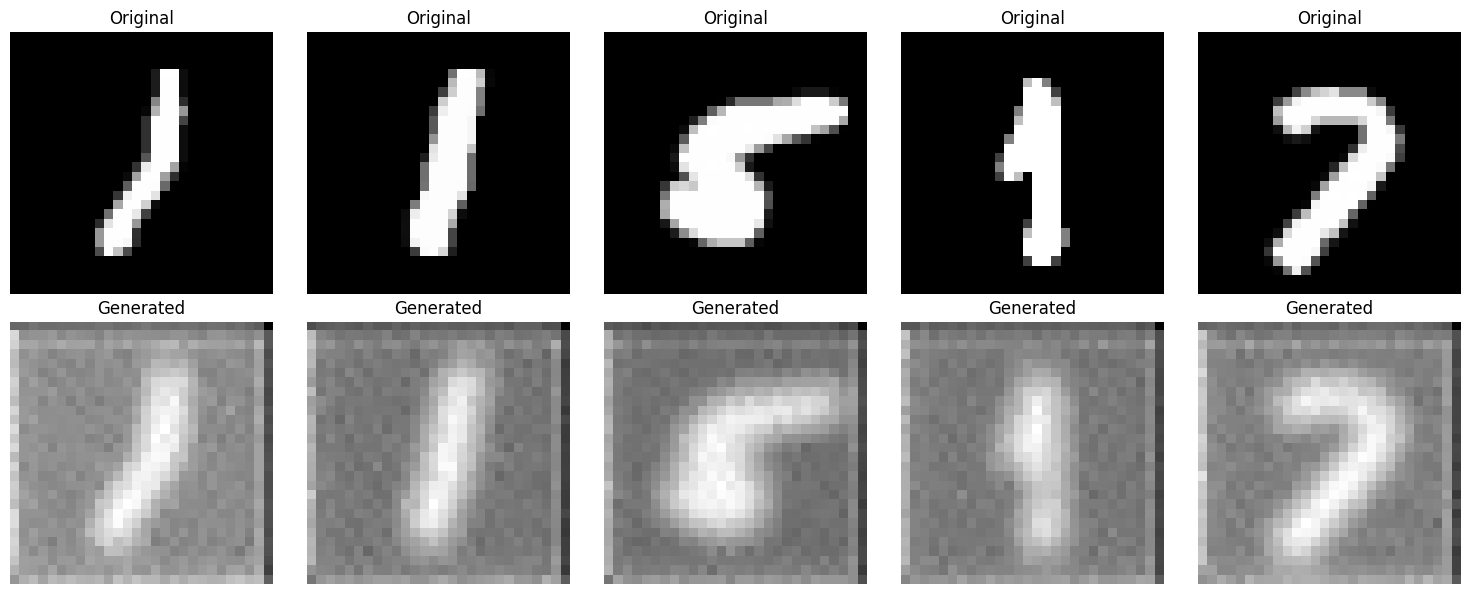

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import os

# Define Improved NCA Model with digit awareness
class ImprovedNCA(nn.Module):
    def __init__(self, channels=32, update_rate=0.5, label_embedding_dim=8):
        super().__init__()
        self.update_rate = update_rate
        self.label_embedding = nn.Embedding(10, label_embedding_dim)
        self.input_channels = channels + label_embedding_dim
        self.model = nn.Sequential(
            nn.Conv2d(self.input_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, channels, 1)
        )

    def forward(self, x, labels):
        label_embed = self.label_embedding(labels).unsqueeze(-1).unsqueeze(-1)
        label_embed = label_embed.expand(-1, -1, x.shape[2], x.shape[3])
        x_input = torch.cat([x, label_embed], dim=1)
        dx = self.model(x_input)
        update_mask = (torch.rand_like(x[:, :1, :, :]) < self.update_rate).float()
        return x + dx * update_mask

import torch.nn.functional as F

def initialize_grid(images, channels=32, device='cpu'):
    blurred = F.avg_pool2d(images, kernel_size=5, stride=1, padding=2)
    grid = torch.zeros((images.size(0), channels, 28, 28), device=device)
    grid[:, :1, :, :] = blurred
    return grid

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
full_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Load Data and preprocess
def get_full_digit_loader(batch_size=64):
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_set, val_set = random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Fine-tuning NCA with pretrained weights
def finetune_unified_nca(epochs=20, device='cpu'):
    model = ImprovedNCA().to(device)
    try:
        for digit in range(10):
            state_dict = torch.load(f'models/nca_digit_{digit}.pth', map_location=device)
            model.load_state_dict(state_dict, strict=False)
        print("Preloaded digit-specific weights into unified NCA.")
    except:
        print("Could not load all digit models. Proceeding with default initialization.")

    train_loader, val_loader = get_full_digit_loader()
    optimizer = optim.AdamW(model.parameters(), lr=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            grid = initialize_grid(images, device=device)

            optimizer.zero_grad()
            intermediate_losses = []
            for step in range(128):
                grid = model(grid, labels)
                if step % 16 == 0 or step == 127:
                    output = grid[:, :1, :, :]
                    loss = loss_fn(output, images)
                    intermediate_losses.append(loss)

            total_loss = sum(intermediate_losses) / len(intermediate_losses)
            total_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += total_loss.item()

        scheduler.step()

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                grid = initialize_grid(images, device=device)
                for _ in range(128):
                    grid = model(grid, labels)
                output = grid[:, :1, :, :]
                loss = loss_fn(output, images)
                total_val_loss += loss.item()

        print(f"[Unified NCA] Epoch {epoch+1}: Train Loss = {total_train_loss/len(train_loader):.4f}, Val Loss = {total_val_loss/len(val_loader):.4f}")

    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), 'models/unified_nca_model.pth')
    print("Unified model saved.")
    return model

# Trigger fine-tuning

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = finetune_unified_nca(epochs=20, device=device)

# Evaluation and visualization
def evaluate_visualize(model, device='cpu', threshold=0.5):
    model.eval()
    test_loader = DataLoader(full_dataset, batch_size=5, shuffle=True)
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)

    grid = initialize_grid(images, device=device)

    with torch.no_grad():
        for _ in range(128):
            grid = model(grid, labels)

    output = grid[:, :1, :, :]
    predicted = (output > threshold).float()

    correct_pixels = (predicted == (images > threshold).float()).sum().item()
    total_pixels = torch.numel(images)
    accuracy = (correct_pixels / total_pixels) * 100
    print(f"Pixel Accuracy: {accuracy:.2f}%")

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axes[0, i].imshow(images[i, 0].cpu().numpy(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(output[i, 0].cpu().numpy(), cmap='gray')
        axes[1, i].set_title("Generated")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Run evaluation
evaluate_visualize(model, device=device)
